# Pipeline processing

This notebook demonstrates the continuum imaging and ICAL pipelines.

In [19]:
%matplotlib inline

import os
import sys
sys.path.append(os.path.join('..','..'))

results_dir = './results'
os.makedirs(results_dir, exist_ok=True)

from matplotlib import pylab

pylab.rcParams['figure.figsize'] = (12.0, 12.0)
pylab.rcParams['image.cmap'] = 'rainbow'

import numpy

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs.utils import pixel_to_skycoord

from matplotlib import pyplot as plt

from arl.calibration.solvers import solve_gaintable
from arl.calibration.operations import apply_gaintable, create_gaintable_from_blockvisibility
from arl.data.data_models import Image
from arl.data.polarisation import PolarisationFrame
from arl.data.parameters import get_parameter
from arl.visibility.base import create_blockvisibility, copy_visibility
from arl.skycomponent.operations import create_skycomponent
from arl.image.operations import show_image, export_image_to_fits, qa_image, copy_image, create_empty_image_like
from arl.visibility.iterators import vis_timeslice_iter
from arl.visibility.coalesce import convert_visibility_to_blockvisibility
from arl.util.testing_support import create_named_configuration, create_low_test_beam, \
    simulate_gaintable, create_low_test_skycomponents_from_gleam
from arl.skycomponent.operations import apply_beam_to_skycomponent
from arl.imaging import create_image_from_visibility, advise_wide_field, predict_skycomponent_visibility
from arl.imaging.imaging_context import invert_function, predict_function
from arl.pipelines.functions import ical

import logging

log = logging.getLogger()
log.setLevel(logging.INFO)
log.addHandler(logging.StreamHandler(sys.stdout))

We create a graph to make the visibility. The parameter rmax determines the distance of the furthest antenna/stations used. All over parameters are determined from this number.

In [20]:
nfreqwin=2
ntimes=3
rmax=300.0
frequency=numpy.linspace(0.8e8,1.2e8,nfreqwin)
channel_bandwidth=numpy.array(nfreqwin*[frequency[1]-frequency[0]])
times = numpy.linspace(-numpy.pi/3.0, numpy.pi/3.0, ntimes)
phasecentre=SkyCoord(ra=+30.0 * u.deg, dec=-60.0 * u.deg, frame='icrs', equinox='J2000')

lowcore = create_named_configuration('LOWBD2-CORE', rmax=rmax)

block_vis = create_blockvisibility(lowcore, times, frequency=frequency, channel_bandwidth=channel_bandwidth,
                     weight=1.0, phasecentre=phasecentre,
                     polarisation_frame=PolarisationFrame("stokesI"))

create_blockvisibility: 3 rows, 0.002 GB


create_blockvisibility: 3 rows, 0.002 GB


create_blockvisibility: 3 rows, 0.002 GB


In [21]:
wprojection_planes=1
advice=advise_wide_field(block_vis, guard_band_image=4.0, delA=0.02,
                             wprojection_planes=wprojection_planes)

vis_slices = advice['vis_slices']
npixel=advice['npixels2']
cellsize=advice['cellsize']

advise_wide_field: Maximum wavelength 3.747 (meters)


advise_wide_field: Maximum wavelength 3.747 (meters)


advise_wide_field: Maximum wavelength 3.747 (meters)


advise_wide_field: Minimum wavelength 2.498 (meters)


advise_wide_field: Minimum wavelength 2.498 (meters)


advise_wide_field: Minimum wavelength 2.498 (meters)


advise_wide_field: Maximum baseline 227.9 (wavelengths)


advise_wide_field: Maximum baseline 227.9 (wavelengths)


advise_wide_field: Maximum baseline 227.9 (wavelengths)


advise_wide_field: Station/antenna diameter 35.0 (meters)


advise_wide_field: Station/antenna diameter 35.0 (meters)


advise_wide_field: Station/antenna diameter 35.0 (meters)


advise_wide_field: Primary beam 0.107069 (rad) 6.135 (deg)


advise_wide_field: Primary beam 0.107069 (rad) 6.135 (deg)


advise_wide_field: Primary beam 0.107069 (rad) 6.135 (deg)


advise_wide_field: Image field of view 0.428275 (rad) 24.538 (deg)


advise_wide_field: Image field of view 0.428275 (rad) 24.538 (deg)


advise_wide_field: Image field of view 0.428275 (rad) 24.538 (deg)


advise_wide_field: Synthesized beam 0.004388 (rad) 0.251 (deg)


advise_wide_field: Synthesized beam 0.004388 (rad) 0.251 (deg)


advise_wide_field: Synthesized beam 0.004388 (rad) 0.251 (deg)


advise_wide_field: Cellsize 0.001463 (rad) 0.084 (deg)


advise_wide_field: Cellsize 0.001463 (rad) 0.084 (deg)


advise_wide_field: Cellsize 0.001463 (rad) 0.084 (deg)


advice_wide_field: Npixels per side = 293


advice_wide_field: Npixels per side = 293


advice_wide_field: Npixels per side = 293


advice_wide_field: Npixels (power of 2, 3) per side = 384


advice_wide_field: Npixels (power of 2, 3) per side = 384


advice_wide_field: Npixels (power of 2, 3) per side = 384


advice_wide_field: W sampling for full image = 0.3 (wavelengths)


advice_wide_field: W sampling for full image = 0.3 (wavelengths)


advice_wide_field: W sampling for full image = 0.3 (wavelengths)


advice_wide_field: W sampling for primary beam = 5.6 (wavelengths)


advice_wide_field: W sampling for primary beam = 5.6 (wavelengths)


advice_wide_field: W sampling for primary beam = 5.6 (wavelengths)


advice_wide_field: Time sampling for full image = 41.9 (s)


advice_wide_field: Time sampling for full image = 41.9 (s)


advice_wide_field: Time sampling for full image = 41.9 (s)


advice_wide_field: Time sampling for primary beam = 670.1 (s)


advice_wide_field: Time sampling for primary beam = 670.1 (s)


advice_wide_field: Time sampling for primary beam = 670.1 (s)


advice_wide_field: Frequency sampling for full image = 58168.9 (Hz)


advice_wide_field: Frequency sampling for full image = 58168.9 (Hz)


advice_wide_field: Frequency sampling for full image = 58168.9 (Hz)


advice_wide_field: Frequency sampling for primary beam = 930702.7 (Hz)


In [22]:
model = create_image_from_visibility(block_vis, npixel=npixel, frequency=[numpy.average(frequency)], nchan=nfreqwin,
    channel_bandwidth=[numpy.sum(channel_bandwidth)], cellsize=cellsize, phasecentre=phasecentre)

create_image_from_visibility: Parsing parameters to get definition of WCS


create_image_from_visibility: Parsing parameters to get definition of WCS


create_image_from_visibility: Parsing parameters to get definition of WCS


create_image_from_visibility: Defining 2 channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    ( 30., -60.)>, starting frequency 100000000.0 Hz, and bandwidth [ 80000000.] Hz


create_image_from_visibility: Defining 2 channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    ( 30., -60.)>, starting frequency 100000000.0 Hz, and bandwidth [ 80000000.] Hz


create_image_from_visibility: Defining 2 channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    ( 30., -60.)>, starting frequency 100000000.0 Hz, and bandwidth [ 80000000.] Hz


create_image_from_visibility: uvmax = 101.803178 wavelengths


create_image_from_visibility: uvmax = 101.803178 wavelengths


create_image_from_visibility: uvmax = 101.803178 wavelengths


create_image_from_visibility: Critical cellsize = 0.004911 radians, 0.281405 degrees


create_image_from_visibility: Critical cellsize = 0.004911 radians, 0.281405 degrees


create_image_from_visibility: Critical cellsize = 0.004911 radians, 0.281405 degrees


create_image_from_visibility: Cellsize          = 0.001463 radians, 0.083797 degrees


create_image_from_visibility: Cellsize          = 0.001463 radians, 0.083797 degrees


create_image_from_visibility: Cellsize          = 0.001463 radians, 0.083797 degrees


In [24]:
corrupted_vis = copy_visibility(block_vis)
gt = create_gaintable_from_blockvisibility(block_vis, timeslice='auto')
for sc in gleam_components:
    component_vis = copy_visibility(block_vis, zero=True)
    gt = simulate_gaintable(gt, amplitude_error=0.0, phase_error=0.1)
    component_vis = predict_skycomponent_visibility(component_vis, sc)
    component_vis = apply_gaintable(component_vis, gt)
    corrupted_vis.data['vis'][...]+=component_vis.data['vis'][...]

In [ ]:
predicted_vis = predict_function(block_vis, gleam_model, vis_slices=51, context='wstack')
block_vis=convert_visibility_to_blockvisibility(predicted_vis)
gt = create_gaintable_from_blockvisibility(block_vis)
gt = simulate_gaintable(gt, phase_error=1.0)
blockvis = apply_gaintable(block_vis, gt)

In [25]:
model = create_image_from_visibility(block_vis, npixel=npixel, frequency=[numpy.average(frequency)], nchan=1,
    channel_bandwidth=[numpy.sum(channel_bandwidth)], cellsize=cellsize, phasecentre=phasecentre)

create_image_from_visibility: Parsing parameters to get definition of WCS


create_image_from_visibility: Parsing parameters to get definition of WCS


create_image_from_visibility: Parsing parameters to get definition of WCS


create_image_from_visibility: Defining single channel MFS Image at <SkyCoord (ICRS): (ra, dec) in deg
    ( 30., -60.)>, starting frequency 100000000.0 Hz, and bandwidth [ 80000000.] Hz


create_image_from_visibility: Defining single channel MFS Image at <SkyCoord (ICRS): (ra, dec) in deg
    ( 30., -60.)>, starting frequency 100000000.0 Hz, and bandwidth [ 80000000.] Hz


create_image_from_visibility: Defining single channel MFS Image at <SkyCoord (ICRS): (ra, dec) in deg
    ( 30., -60.)>, starting frequency 100000000.0 Hz, and bandwidth [ 80000000.] Hz


create_image_from_visibility: uvmax = 101.803178 wavelengths


create_image_from_visibility: uvmax = 101.803178 wavelengths


create_image_from_visibility: uvmax = 101.803178 wavelengths


create_image_from_visibility: Critical cellsize = 0.004911 radians, 0.281405 degrees


create_image_from_visibility: Critical cellsize = 0.004911 radians, 0.281405 degrees


create_image_from_visibility: Critical cellsize = 0.004911 radians, 0.281405 degrees


create_image_from_visibility: Cellsize          = 0.001463 radians, 0.083797 degrees


create_image_from_visibility: Cellsize          = 0.001463 radians, 0.083797 degrees


create_image_from_visibility: Cellsize          = 0.001463 radians, 0.083797 degrees


In [27]:
dirty, sumwt = invert_function(corrupted_vis, model, vis_slices=vis_slices, dopsf=False, context='wstack')

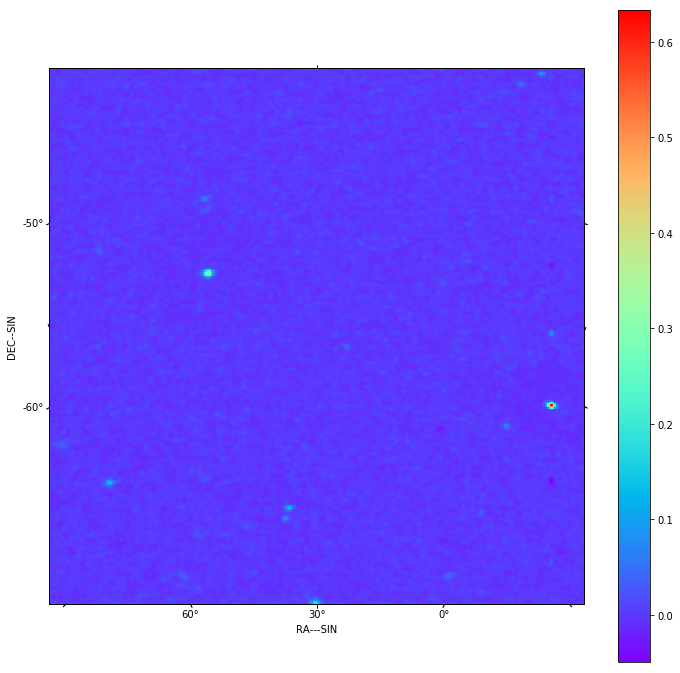

In [28]:
show_image(dirty)
plt.show()

In [ ]:
deconvolved, residual, restored = ical(block_vis=blockvis, model=model, vis_slices=vis_slices, timeslice='auto',
                                       algorithm='hogbom', niter=1000, fractional_threshold=0.1, threshold=0.1,
                                       context='wstack', nmajor=5, gain=0.1, 
                                       T_first_selfcal=2,
                                       G_first_selfcal=3,
                                       B_first_selfcal=4,
                                       global_solution=False)

In [ ]:
f = show_image(deconvolved, title='Clean image')
print(qa_image(deconvolved, context='Clean image'))
plt.show()

f = show_image(residual, title='Residual clean image')
print(qa_image(residual, context='Residual clean image'))
plt.show()
export_image_to_fits(residual, '%s/imaging-ical_residual.fits'
                     % (results_dir))

f = show_image(restored, title='Restored clean image')
print(qa_image(restored, context='Restored clean image'))
plt.show()
export_image_to_fits(restored, '%s/imaging-ical_restored.fits'
                     % (results_dir))